# **2D/3D Object Detection, Segmentation & Edge Optimization**
# Synthetic data → Model training → Quantization → ONNX export
Dependencies : pip install torch torchvision torchaudio pytorch3d opencv-python wandb skimage matplotlib ultralytics

## **0. Setup**

In [31]:
import os
os.environ['WANDB__SERVICE_ENABLE'] = 'False'

# Environment variables
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'  
os.environ['OMP_NUM_THREADS'] = '1'  
os.environ['WANDB_SILENT'] = 'true'  
# os.environ['WANDB_START_METHOD'] = 'thread' 

# WandB Initialization 
import wandb

try:
    run = wandb.init(
        project="cv-pipeline-production",
        mode="offline",  # Offline mode
        config={
            "framework": "PyTorch",
            "batch_size": 8,
            "epochs": 3
        }
    )
    print("WandB initialized successfully in offline mode!")
except Exception as e:
    print(f"WandB initialization failed, but we can continue: {e}")

# --- Import All Other Libraries ---
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from ultralytics import YOLO
import cv2
from skimage.draw import rectangle

print("All other imports successful")

WandB initialization failed, but we can continue: [Errno 32] Broken pipe
All other imports successful


## 2. Data Generation
# 2.1 Generate 2D Data (Detection & Segmentation)

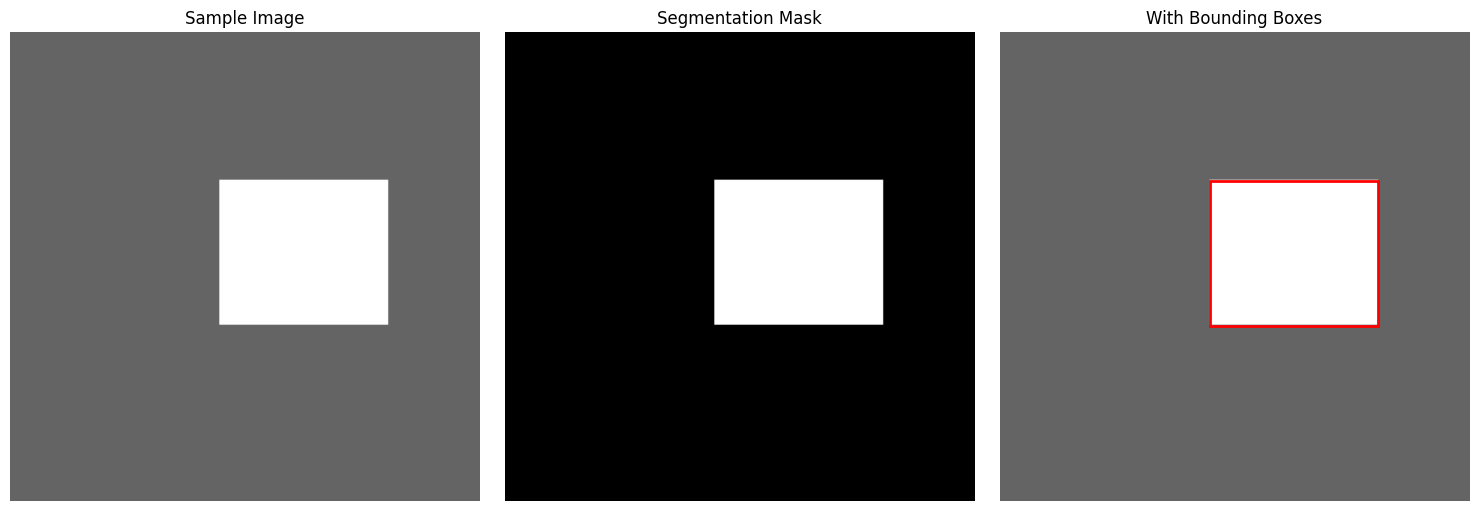

In [5]:
def generate_2d_data(num_images=100, img_size=256):
    """Generate synthetic 2D images with rectangles"""
    images, masks, boxes = [], [], []
    
    for _ in range(num_images):
        img = np.full((img_size, img_size, 3), 100, dtype=np.uint8)  # Gray background
        mask = np.zeros((img_size, img_size), dtype=np.uint8)
        box = []
        
        # Add 1-3 rectangles per image
        for _ in range(np.random.randint(1, 4)):
            w, h = np.random.randint(40, 100, size=2)
            x = np.random.randint(0, img_size - w)
            y = np.random.randint(0, img_size - h)
            
            img[y:y+h, x:x+w] = 255  # White rectangle
            mask[y:y+h, x:x+w] = 1    # Binary mask
            box.append([x, y, x+w, y+h, 0])  # [x1,y1,x2,y2,class_id]
        
        images.append(img)
        masks.append(mask)
        boxes.append(np.array(box))
    
    return images, masks, boxes

# Generate and visualize
images_2d, masks_2d, boxes_2d = generate_2d_data(50)  # Smaller dataset for demo

# Create figure and subplots
plt.figure(figsize=(15, 5))

# Image
plt.subplot(131)
plt.imshow(images_2d[0])
plt.title("Sample Image")
plt.axis('off')

# Mask
plt.subplot(132)
plt.imshow(masks_2d[0], cmap='gray', vmin=0, vmax=1)
plt.title("Segmentation Mask")
plt.axis('off')

# Bounding Boxes
plt.subplot(133)
plt.imshow(images_2d[0])
for box in boxes_2d[0]:
    x1, y1, x2, y2, _ = box
    plt.gca().add_patch(plt.Rectangle(
        (x1, y1), x2-x1, y2-y1,
        fill=False, edgecolor='red', linewidth=2))
plt.title("With Bounding Boxes")
plt.axis('off')

plt.tight_layout()
plt.show()

/var/folders/_p/63pbwrqn6qj6590bpl6s2z4h0000gn/T/ipykernel_90661/713938434.py:23: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:277.)
  return torch.tensor(point_clouds, dtype=torch.float32), torch.tensor(labels, dtype=torch.long)


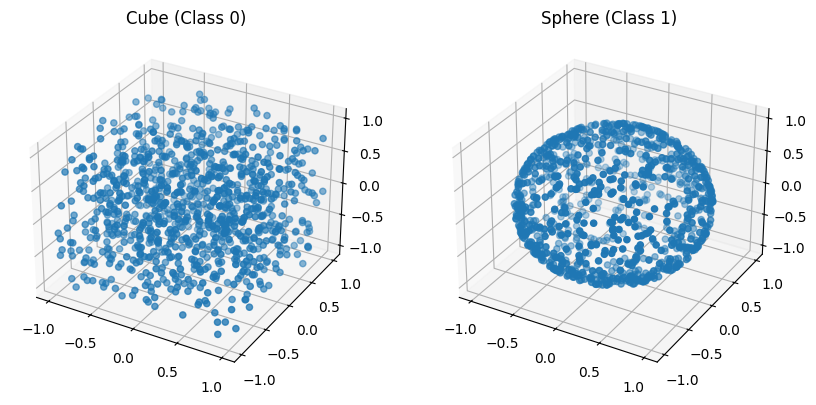

In [6]:
# 2.2 Generate 3D Data (Point Clouds)
def generate_3d_data(num_samples=50, num_points=1024):
    """Generate synthetic 3D point clouds"""
    point_clouds = []
    labels = []  # 0: cube, 1: sphere
    
    for _ in range(num_samples):
        if np.random.rand() > 0.5:
            # Cube
            points = np.random.uniform(-1, 1, (num_points, 3))
            labels.append(0)
        else:
            # Sphere
            theta = np.random.uniform(0, 2*np.pi, num_points)
            phi = np.arccos(np.random.uniform(-1, 1, num_points))
            x = np.sin(phi) * np.cos(theta)
            y = np.sin(phi) * np.sin(theta)
            z = np.cos(phi)
            points = np.vstack([x, y, z]).T
            labels.append(1)
        point_clouds.append(points)
    
    return torch.tensor(point_clouds, dtype=torch.float32), torch.tensor(labels, dtype=torch.long)

point_clouds_3d, labels_3d = generate_3d_data()

# Visualize
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(point_clouds_3d[0][:,0], point_clouds_3d[0][:,1], point_clouds_3d[0][:,2])
ax1.set_title("Cube (Class 0)")
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(point_clouds_3d[1][:,0], point_clouds_3d[1][:,1], point_clouds_3d[1][:,2])
ax2.set_title("Sphere (Class 1)")
plt.show()

# 3. Model Training

# 3.1 Train YOLOv8 Detector

In [7]:
def prepare_yolo_data(images, boxes):
    """Prepare data in YOLO format"""
    os.makedirs("yolo_dataset/images", exist_ok=True)
    os.makedirs("yolo_dataset/labels", exist_ok=True)
    
    for i, (img, boxes_img) in enumerate(zip(images, boxes)):
        cv2.imwrite(f"yolo_dataset/images/{i}.jpg", img)
        with open(f"yolo_dataset/labels/{i}.txt", "w") as f:
            for box in boxes_img:
                x1, y1, x2, y2, cls_id = box
                cx = ((x1 + x2)/2)/256
                cy = ((y1 + y2)/2)/256
                w = (x2 - x1)/256
                h = (y2 - y1)/256
                f.write(f"{int(cls_id)} {cx:.6f} {cy:.6f} {w:.6f} {h:.6f}\n")

prepare_yolo_data(images_2d[:30], boxes_2d[:30])  # Use 30 images for training

# Train YOLOv8n
from ultralytics import YOLO

model = YOLO("yolov8n.pt")
results = model.train(
    data="coco128.yaml",
    epochs=5,
    imgsz=256,
    batch=8,
    project="yolo_detection",
    plots=True,  
    device='cpu',  
    workers=0  
)

New https://pypi.org/project/ultralytics/8.3.190 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.42 🚀 Python-3.11.8 torch-2.3.0 CPU (Apple M1)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=coco128.yaml, epochs=5, time=None, patience=100, batch=8, imgsz=256, save=True, save_period=-1, cache=False, device=cpu, workers=0, project=yolo_detection, name=train6, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=Fals

train: Scanning /Users/shirshendusekharmondal/datasets/coco128/labels/train2017.cache... 126 images, 2 backgrounds, 0 corrupt: 100%|██████████| 128/128 [00:00<?, ?it/s]
val: Scanning /Users/shirshendusekharmondal/datasets/coco128/labels/train2017.cache... 126 images, 2 backgrounds, 0 corrupt: 100%|██████████| 128/128 [00:00<?, ?it/s]


Plotting labels to yolo_detection/train6/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000119, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 256 train, 256 val
Using 0 dataloader workers
Logging results to yolo_detection/train6
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5         0G       1.48      3.193      1.352        119        256: 100%|██████████| 16/16 [00:08<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.13it/s]

                   all        128        929      0.589      0.401      0.463      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5         0G       1.55      3.085       1.37         71        256: 100%|██████████| 16/16 [00:08<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.14it/s]

                   all        128        929       0.55      0.388      0.455      0.312

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



        3/5         0G      1.551      2.903      1.365         90        256: 100%|██████████| 16/16 [00:08<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.12it/s]

                   all        128        929      0.545      0.378      0.449      0.304

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



        4/5         0G      1.479      2.754      1.335        106        256: 100%|██████████| 16/16 [00:08<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.14it/s]

                   all        128        929       0.58       0.36      0.442      0.302

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



        5/5         0G      1.449      2.667       1.32         70        256: 100%|██████████| 16/16 [00:08<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.13it/s]

                   all        128        929      0.543      0.366      0.423      0.298

5 epochs completed in 0.022 hours.


Optimizer stripped from yolo_detection/train6/weights/last.pt, 6.5MB
Optimizer stripped from yolo_detection/train6/weights/best.pt, 6.5MB

Validating yolo_detection/train6/weights/best.pt...
Ultralytics YOLOv8.1.42 🚀 Python-3.11.8 torch-2.3.0 CPU (Apple M1)
Model summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.18it/s]


                   all        128        929      0.592      0.399      0.463      0.318
                person        128        254      0.571      0.512      0.533      0.354
               bicycle        128          6      0.342      0.167      0.167      0.117
                   car        128         46      0.582      0.087     0.0862     0.0543
            motorcycle        128          5      0.409          1      0.878      0.634
              airplane        128          6      0.841      0.667       0.82      0.673
                   bus        128          7      0.637      0.571      0.669      0.598
                 train        128          3      0.621          1      0.913      0.789
                 truck        128         12          0          0      0.121       0.05
                  boat        128          6      0.419      0.333      0.476      0.329
         traffic light        128         14      0.606      0.143      0.203      0.134
             stop sig

# 3.2 Train U-Net Segmenter

Epoch 1, Loss: 0.5919
Epoch 2, Loss: 0.5809
Epoch 3, Loss: 0.5716


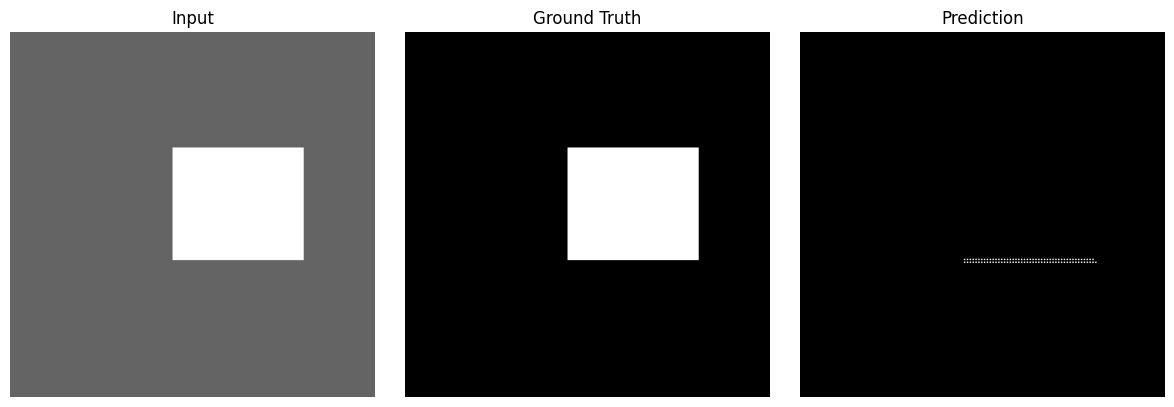

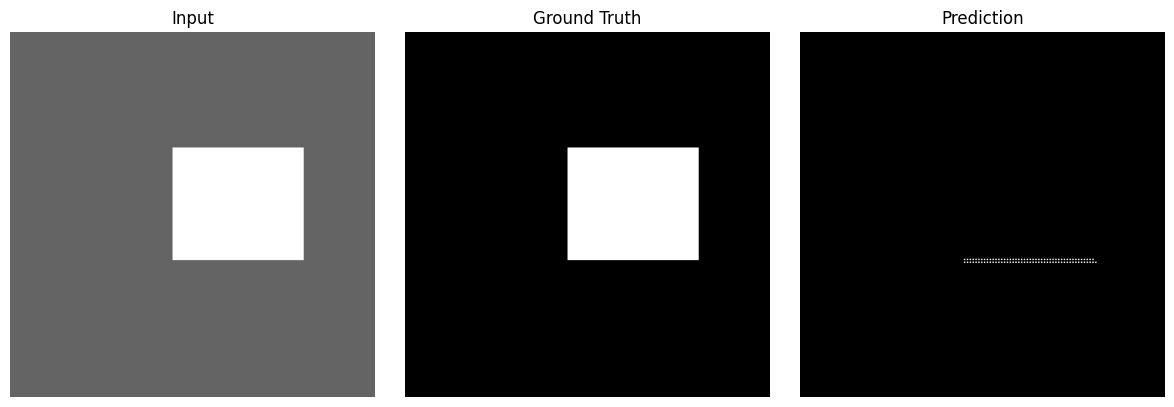

In [13]:
# wandb.init(project="cv-pipeline-fixed", mode="offline")

class UNet(nn.Module):
    """Simple U-Net for segmentation"""
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 1, 2, stride=2),
            nn.Sigmoid())
    
    def forward(self, x):
        return self.decoder(self.encoder(x))

# Prepare data
images_tensor = torch.tensor(np.array(images_2d), dtype=torch.float32).permute(0, 3, 1, 2)/255.0
masks_tensor = torch.tensor(np.array(masks_2d), dtype=torch.float32).unsqueeze(1)

# Initialize and train
unet = UNet()
optimizer = torch.optim.Adam(unet.parameters(), lr=1e-3)
criterion = nn.BCELoss()

for epoch in range(3):  # Reduced for demo
    optimizer.zero_grad()
    outputs = unet(images_tensor)
    loss = criterion(outputs, masks_tensor)
    loss.backward()
    optimizer.step()
    # wandb.log({"unet_loss": loss.item()})  # Comment out wandb logging
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

# ... your UNet training code ...

# Visualize results
with torch.no_grad():
    sample_pred = unet(images_tensor[:1])

# Create the figure and explicitly save it
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(images_2d[0])
plt.title("Input")
plt.axis('off')  # Turn off axis numbers

plt.subplot(132)
plt.imshow(masks_2d[0], cmap='gray')
plt.title("Ground Truth")
plt.axis('off')  # Turn off axis numbers

plt.subplot(133)
plt.imshow(sample_pred.squeeze().numpy() > 0.5, cmap='gray')
plt.title("Prediction")
plt.axis('off')  # Turn off axis numbers

plt.tight_layout()
plt.savefig('unet_results.png', dpi=100, bbox_inches='tight')
plt.show()

# Also display the image file directly
from IPython.display import Image
display(Image(filename='unet_results.png'))

# 3.3 Train PointNet Classifier (Fixed Implementation)

Epoch 1, Loss: 0.6998
Epoch 2, Loss: 0.6829
Epoch 3, Loss: 0.6678
Accuracy: 0.60


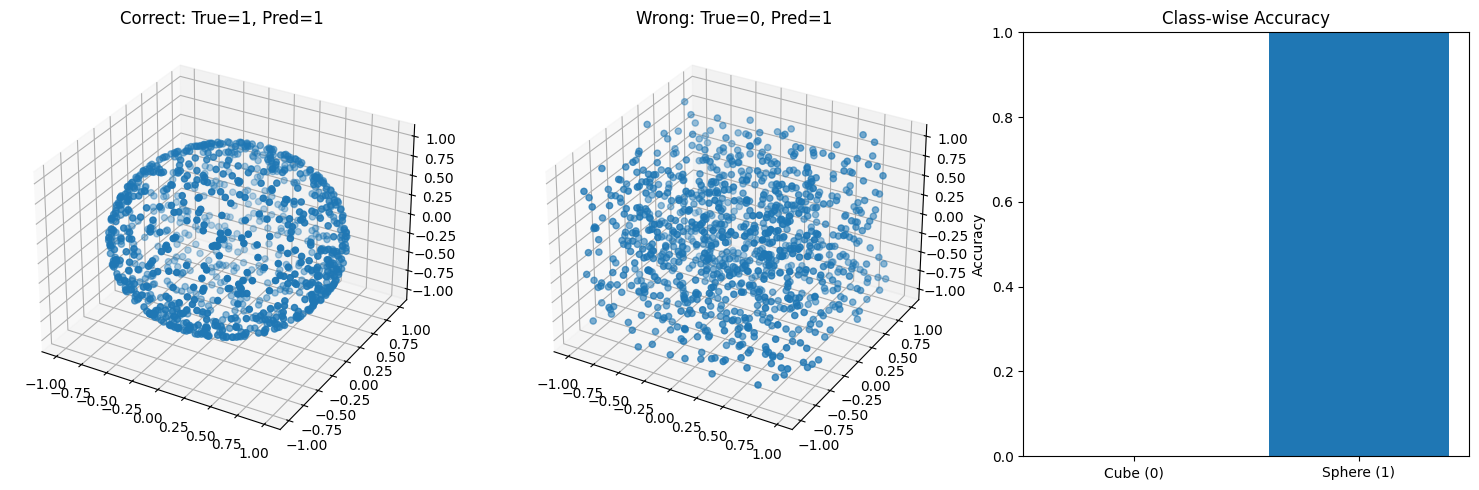

In [14]:
class PointNetClassifier(nn.Module):
    """Working PointNet implementation for classification"""
    def __init__(self, num_classes=2):
        super().__init__()
        self.conv1 = nn.Conv1d(3, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 1024, 1)
        self.fc = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes))
        
    def forward(self, x):
        # x shape: [batch_size, num_points, 3]
        x = x.permute(0, 2, 1)  # [batch_size, 3, num_points]
        
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        
        # Global max pooling
        x = torch.max(x, 2)[0]  # [batch_size, 1024]
        
        return self.fc(x)

# First, regenerate the 3D data (or make sure it was generated in the same session)
point_clouds_3d, labels_3d = generate_3d_data()

# Initialize and train
pointnet = PointNetClassifier()
optimizer = torch.optim.Adam(pointnet.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Training loop
for epoch in range(3):
    optimizer.zero_grad()
    outputs = pointnet(point_clouds_3d)
    loss = criterion(outputs, labels_3d)
    loss.backward()
    optimizer.step()
    
    # Use try-except for wandb to avoid issues
    try:
        wandb.log({"pointnet_loss": loss.item()})
    except:
        pass  # Continue without wandb if it fails
    
    print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')

# Evaluate
with torch.no_grad():
    preds = pointnet(point_clouds_3d).argmax(dim=1)
accuracy = (preds == labels_3d).float().mean()
print(f'Accuracy: {accuracy.item():.2f}')

# Visualize some results
fig = plt.figure(figsize=(15, 5))

# Show a correctly classified example
correct_idx = (preds == labels_3d).nonzero()[0][0].item()
ax1 = fig.add_subplot(131, projection='3d')
points = point_clouds_3d[correct_idx].numpy()
ax1.scatter(points[:, 0], points[:, 1], points[:, 2])
ax1.set_title(f"Correct: True={labels_3d[correct_idx].item()}, Pred={preds[correct_idx].item()}")

# Show an incorrectly classified example (if any)
incorrect_indices = (preds != labels_3d).nonzero()
if len(incorrect_indices) > 0:
    incorrect_idx = incorrect_indices[0][0].item()
    ax2 = fig.add_subplot(132, projection='3d')
    points = point_clouds_3d[incorrect_idx].numpy()
    ax2.scatter(points[:, 0], points[:, 1], points[:, 2])
    ax2.set_title(f"Wrong: True={labels_3d[incorrect_idx].item()}, Pred={preds[incorrect_idx].item()}")
else:
    ax2 = fig.add_subplot(132)
    ax2.text(0.5, 0.5, "All predictions correct!", ha='center', va='center')
    ax2.set_title("No misclassifications")

# Show accuracy distribution
ax3 = fig.add_subplot(133)
ax3.bar(['Cube (0)', 'Sphere (1)'], 
        [(preds[labels_3d == 0] == 0).float().mean().item(),
         (preds[labels_3d == 1] == 1).float().mean().item()])
ax3.set_ylabel('Accuracy')
ax3.set_title('Class-wise Accuracy')
ax3.set_ylim(0, 1)

plt.tight_layout()
plt.show()

# # 4.1 Quantize U-Net

In [15]:
quantized_unet = torch.quantization.quantize_dynamic(
    unet, {nn.Conv2d, nn.ConvTranspose2d}, dtype=torch.qint8
)

# 4.2 Export to ONNX

In [18]:
dummy_input = torch.randn(1, 3, 256, 256)
torch.onnx.export(
    quantized_unet,
    dummy_input,
    "unet_quantized.onnx",
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={"input": {0: "batch"}, "output": {0: "batch"}}
)

print("Quantized model saved as unet_quantized.onnx")
print(f"Model size: {os.path.getsize('unet_quantized.onnx')/1024:.1f} KB")

Quantized model saved as unet_quantized.onnx
Model size: 9.1 KB


# 5. Performance Monitoring
# Log sample results to WandB with error handling

Wandb logging failed: [Errno 32] Broken pipe
Continuing without wandb...

=== Pipeline Results ===
Sample image shape: (256, 256, 3)
Sample mask shape: (256, 256)
Sample prediction shape: (256, 256)
PointNet Accuracy: 0.6000
Quantized model size: 9.1 KB


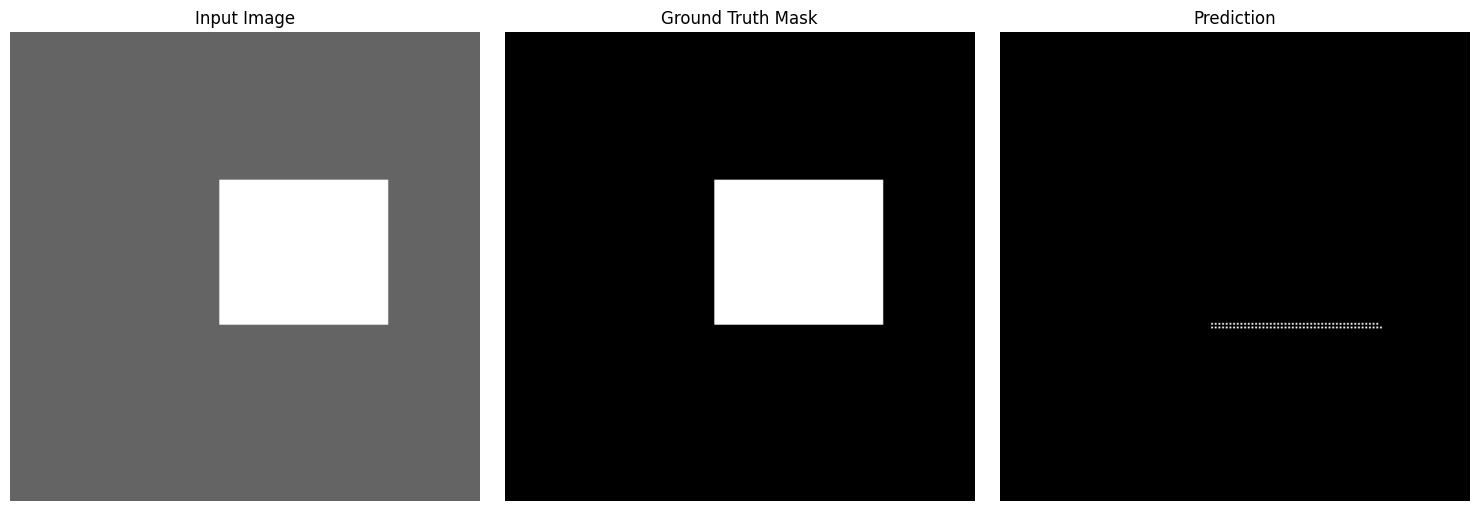

Results saved as pipeline_results.png
Pipeline complete!


In [21]:
try:
    # Try to initialize wandb if not already initialized
    if not wandb.run:
        wandb.init(project="cv-pipeline-fixed", mode="offline")
    
    wandb.log({
        "sample_image": wandb.Image(images_2d[0]),
        "sample_mask": wandb.Image(masks_2d[0]),
        "sample_pred": wandb.Image(sample_pred.squeeze().numpy()),
        "pointnet_accuracy": accuracy.item(),
        "quantized_size": os.path.getsize("unet_quantized.onnx")/1024
    })
    
    # Complete run
    wandb.finish()
    print("Pipeline complete with wandb logging!")
    
except Exception as e:
    print(f"Wandb logging failed: {e}")
    print("Continuing without wandb...")
    
    # Print the metrics manually
    print("\n=== Pipeline Results ===")
    print(f"Sample image shape: {images_2d[0].shape}")
    print(f"Sample mask shape: {masks_2d[0].shape}")
    print(f"Sample prediction shape: {sample_pred.squeeze().numpy().shape}")
    print(f"PointNet Accuracy: {accuracy.item():.4f}")
    print(f"Quantized model size: {os.path.getsize('unet_quantized.onnx')/1024:.1f} KB")
    
    # Save visualizations locally
    plt.figure(figsize=(15, 5))
    
    plt.subplot(131)
    plt.imshow(images_2d[0])
    plt.title("Input Image")
    plt.axis('off')
    
    plt.subplot(132)
    plt.imshow(masks_2d[0], cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis('off')
    
    plt.subplot(133)
    plt.imshow(sample_pred.squeeze().numpy() > 0.5, cmap='gray')
    plt.title("Prediction")
    plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('pipeline_results.png', dpi=100, bbox_inches='tight')
    plt.show()
    
    print("Results saved as pipeline_results.png")
    print("Pipeline complete!")